# Milestone 2 - Data gathering and preprocessing

## 1. Narrowing down the research question

### Research Questions

In this research project we will try to analyse a corpus of popular songs to try to identify  chords differences between verses and choruses. We will try to  answer the following research questions :
<ol>
<li>Does the chord distribution of the choruses differ from the one in the verses?</li>
<li>Is there a different chord sequence distribution in the choruses compared to the verses?</li>
<li>How are these distributions evolving over time? </li>
</ol>

In the first question we want to know if a difference exists in terms of chords statistic. Are we more likely to find a specific chord in the choruses? Are fewer different chords used in the chorus compared to the other parts of a song? <br> 
For the second one we want to have a more melodic insight. Can we find specific patterns? Is the Markov model derived from the chorus different from its counterparts? <br>
In the third one the focus is on the time dimension. We want to know if the results of the two previous answers change over time. Were chorus closer to verses in 1968 than in 1985? How does each chord evolve in relation to the others? Do we find a sequence that appeared while other disappeared? 

These are all the underlying questions we want to answer under our main research questions.  

These questions relate to our original idea to fully characterize a chorus over the years, especially in comparison with verses. We now want to focus specifically on the chords to differentiate these different parts, while keeping the temporal dimension as a potential factor to observe changes.

### Dataset presentation

To give us the means to answer our questions, we have selected a dataset containing approximately 900 Pop-Rock songs in the top Billboard charts from the 60s to the 90s. They are simple text files with the following informations : 
* Release date
* Song title 
* Artist name
* Labels for the different parts of the song (such as chorus or verse)
* Timestamp of each musical phrase beginning
* Chords

### Procedure

We will use the chorus/verse annotations to classify the chords in each group. This will allow us to divide the chords in two groups and compute statistics and distributions for each of them. As discussed in the research questions, we will start with a basic characterization, simply comparing which chords appear in which section. We will then move deeper and compare the distributions of chords as well as the Markov models. These will be computed at least with bigrams, perhaps with higher-n n-grams depending on the number of chords in each section (as it makes little sense to use n-grams with n close to the number of chords in a given section).

The metadata, especially the release date, will be used to study the evolution over time of the previously discussed statistics. Depending on the distribution of songs over the years, time analysis will be discussed either over years or over decades.

### Possible outcomes and confidence measures

The different outcomes we can reasonably expect are: 
<ul>
    <li> <strong>Null results:</strong> There are no significant differences between choruses and verses and no evolution over time. This could be explained by a bias in the corpus toward a specific Pop-Rock genre using the same chords all the time or maybe there is indeed no difference in the chords used in a chorus and the ones used in verses, which would constitute an answer for our questions. </li>
<li> <strong>Narrow chorus chord distribution:</strong> Since the chorus has to be immediately recognized as one, maybe the composers make more extensive use of a sub group of the chords to ensure it. The same reasoning could be applied to the chord sequences: perhaps some specific ones will be more dominant in the chorus.</li>
<li> <strong>Temporal evolution:</strong> It will be interesting to see if the differences between verse and chorus change over the years. This evolution, if present, could be linear or oscillating. A linear narrowing would imply that choruses are becoming more and more similar or verse more and more diverse. An oscillating pattern would be interesting as musical phenomenon could appear and disappear.</li>
</ul>

Statistical tests will be used throughtout our analysis to check if our findings are statistically relevant. Error bars will also be included in all our graphics to avoid wrong conclusions. Of course the relative small size of our corpus will influence our results but only further analysis can reveal if significant results can still be found.

## 2. Gathering the data
The dataset has been created by [1] and corresponds to a random sample of 890 Billboard chart slots presented at ISMIR 2011 and MIREX 2012. Due to the nature of the sampling algorithm, there are some duplicates and this results in only 740 distinct songs. According to the authors, training algorithms that assume independent, identically distributed data should retain the duplicates.<br> This dataset is publicly available at https://ddmal.music.mcgill.ca/research/The_McGill_Billboard_Project_(Chord_Analysis_Dataset)/ and can be downloaded in various formats. Different features are given by the authors. In this project we will use metadata and chords annotations. 
The first dataset used is the index to the dataset (csv format), containing the following fields:
<ul>
<li><b>id</b>, the index for the sample entry.</li>
<li><b>chart_date</b>, the date of the chart for the entry.</li>
<li><b>target_rank</b>, the desired rank on that chart.</li>
<li><b>actual_rank</b>, the rank of the song actually annotated, which may be up to 2 ranks higher or lower than the target rank [1, 2].</li>
<li><b>title</b>, the title of the song annotated.</li>
<li><b>artist</b>, the name of the artist performing the song annotated.</li>
<li><b>peak_rank</b>, the highest rank the song annotated ever achieved on the Billboard Hot 100.</li>
<li><b>weeks_on_chart</b>, the number of weeks the song annotated spent on the Billboard Hot 100 chart in total.</li>
</ul>

The main dataset comprehends chords, structure, instrumentation, and timing, given in a txt format. The annotation for each song begins with a header containing the title of the song, the name of the artist, the metre and the tonic pitch class of the opening key. In the main body, each line consists of a single phrase and begins with its timestamp, followed by the chords. This requires us to design a specific parser, as will be discussed in the next section.<br>
We downloaded the two datasets which constitutes the whole of their database so we have the maximum from this source. It is not excluded that we find some additional ones to perform further analysis. As for now we will try to get as much stastitically relevant information from this source.

[1]: John Ashley Burgoyne, Jonathan Wild, and Ichiro Fujinaga, ‘An Expert Ground Truth Set for Audio Chord Recognition and Music Analysis’, in Proceedings of the 12th International Society for Music Information Retrieval Conference, ed. Anssi Klapuri and Colby Leider (Miami, FL, 2011), pp. 633–38

## 3. Data format

The goal of this question is to load the data and have a look at it. A specific parser is designed to do this automatically, in order to extract and store in a Pandas dataframe all the relevant informations and musical features.

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import cufflinks as cf
cf.go_offline()
cf.set_config_file(theme='white')
import plotly.express as px
import seaborn as sns

### Metadata

In [2]:
metadata_df = pd.read_csv("data/billboard-2.0-index.csv")
metadata_df.head(10)

,id,chart_date,target_rank,actual_rank,title,artist,peak_rank,weeks_on_chart
0,1,1987-07-11,82,NaN,NaN,NaN,NaN,NaN
1,2,1973-08-04,14,NaN,NaN,NaN,NaN,NaN
2,3,1961-07-03,56,57.0,I Don't Mind,James Brown,47.0,8.0
3,4,1971-08-07,32,31.0,You've Got A Friend,"Roberta Flack,Donny Hathaway",29.0,12.0
4,5,1976-07-10,51,NaN,NaN,NaN,NaN,NaN
5,6,1980-08-02,15,16.0,The Rose,Bette Midler,3.0,25.0
6,7,1972-10-07,37,NaN,NaN,NaN,NaN,NaN
7,8,1963-04-13,67,NaN,NaN,NaN,NaN,NaN
8,9,1991-05-25,48,NaN,NaN,NaN,NaN,NaN
9,10,1984-03-24,49,51.0,An Innocent Man,Billy Joel,10.0,18.0


In [3]:
print('There are %d entries in the index table.' %len(metadata_df))

There are 1300 entries in the index table.


In [4]:
print('There are %d entries with a given title.' %metadata_df.title.isna().value_counts()[0])

There are 890 entries with a given title.


In [5]:
print('There are %d entries with a given artist.' %metadata_df.artist.isna().value_counts()[0])

There are 890 entries with a given artist.


In [6]:
print('There are %d entries with a given chart date.' %metadata_df.chart_date.isna().value_counts()[0])

There are 1300 entries with a given chart date.


In [7]:
months = {'01':'January', 
          '02':'February',
          '03':'March',
          '04':'April',
          '05':'May',
          '06':'June',
          '07':'July',
          '08':'August',
          '09':'September',
          '10':'October',
          '11':'November',
          '12':'December'}
def format_date(date):
    year = date[:4]
    month = date[5:7]
    day = date[-2:]
    if day == '01':
        suffix = 'st'
    elif day == '02':
        suffix = 'nd'
    elif day == '03':
        suffix = 'rd'
    else:
        suffix = 'th'
        
    if day[0] == '0':
        day = day[1]
    
    date_string = months[month] + ' ' + day + suffix + ', ' + year
    return(date_string)

#Test
format_date('1958-08-04')

'August 4th, 1958'

In [8]:
print('The songs range from %s to %s.' %(format_date(metadata_df.chart_date.min()), format_date(metadata_df.chart_date.max())))

The songs range from August 18th, 1958 to November 16th, 1991.


### Parser 

In [9]:
SONG_ID, LINE_NUMBER, MEASURE_NUMBER, CHORD_NUMBER, SEQUENCE_NUMBER, \
CHORD, INSTRUMENT, TYPE, TIME, STRUCTURE, DURATION, REPETITION, ELID = \
"song_id","line_id", "measure_id", "chord_id", "sequence_id",\
"chord", "instrument", "section_type", "time", "section_structure", "duration", "repetition", "elided"

#This is dependant of "metre" in the txt files.
METRE = "metre"

#Create a new dictionary from two other
def immutable_merge(dic1, dic2):
    result = dic1.copy()
    result.update(dic2)
    return result

#Create a row of the futur df as a dictionary
def create_row(persistent_attributes, line_attributes,
               measure_number = None, chord_number = None, chord = None, duration = None):
    result = immutable_merge(persistent_attributes, line_attributes)
    
    if not (measure_number is None and measure_number is None and chord_number is None and duration is None):
        result[MEASURE_NUMBER] = measure_number
        result[CHORD_NUMBER] = chord_number
        result[CHORD] = chord
        result[DURATION] = duration
    
    return result

#Generate the attributes of a given line and update the sequence counter
def process_line_metadata(header, line_counter, old_line_attributes, sequence_counter, suffix = ""):
    
    result = {}
    
    #Suffix (main instrument, elid, repetition)
    old_instrument = str(old_line_attributes.get(INSTRUMENT))
    
    for suffix in suffix.split(", "):
        
        suffix = suffix.strip()
        
        #Repetition
        if re.match("^x\d+$",suffix):
            result[REPETITION] = int(suffix[1])
        
        #Elid
        elif suffix == "->":
            result[ELID] = True

        #Instrument
        else:
            ##New instrument
            if len(suffix) > 0 and suffix != "\n":
                result[INSTRUMENT] = suffix.strip("\n").strip(",").strip()

            ##Main instrument continued (experimental)
            elif not old_instrument.endswith(")") and old_instrument.lower() not in ["nan","none"] \
            and len(old_instrument)>0:
                result[INSTRUMENT] = old_instrument.strip("(")

        
    #Line number
    result[LINE_NUMBER] = line_counter

    
    #Header    
    header_items = header.split()
        
    result[TIME] = header_items[0]
    
    #Case where a section is continued
    if len(header_items) == 1:
        result[TYPE] = old_line_attributes.get(TYPE)
        result[STRUCTURE] = old_line_attributes.get(STRUCTURE)
        result[SEQUENCE_NUMBER] = old_line_attributes.get(SEQUENCE_NUMBER)
    
    #Case where a section has no structure (silence, end, fadeout)
    elif len(header_items) == 2:
        
        #Z is a structure, not a type.
        if header_items[1].strip().strip(",") == "Z":
            result[STRUCTURE] = header_items[1].strip().strip(",")
        else:
            result[TYPE] = header_items[1].strip().strip(",")
            
        result[SEQUENCE_NUMBER] = sequence_counter
        sequence_counter += 1
    
    #Case where a section begins.
    elif len(header_items) == 3:
        result[STRUCTURE] = header_items[1].strip().strip(",")
        result[TYPE] = header_items[2].strip().strip(",")
        result[SEQUENCE_NUMBER] = sequence_counter
        sequence_counter += 1
    
    return sequence_counter, result

In [10]:
def parse_song_to_dict(song_id, path):
    
    rows = []
    persistent_attributes = {}
    
    persistent_attributes[SONG_ID] = song_id
    
    with open(path,"r") as file:
        line = file.readline()
        
        line_counter = 0
        measure_counter = 0
        chord_counter = 0
        sequence_counter = 0
        line_attributes = {}
        old_chord = None
 

        while line:
        
            if line != "\n":

                #Attribute lines
                if line.startswith("#"):
                    attribute, value = line.strip("#").split(":",1)
                    persistent_attributes[attribute.strip(" ")] = value.strip(" ").strip("\n")

                else:
                    line_items = line.split("|")

                    #Special lines
                    if len(line_items) <= 1:
                        sequence_counter, line_attributes = \
                        process_line_metadata(line, line_counter, line_attributes, sequence_counter)
                        row = create_row(persistent_attributes, line_attributes)
                        rows.append(row)

                    #Standard lines    
                    else:                    
                        header = line_items[0]
                        suffix = line_items[-1]
                        measures = line_items[1:-1]

                        sequence_counter, line_attributes = \
                        process_line_metadata(header, line_counter, line_attributes, sequence_counter, suffix)  

                        for measure in measures:
                            
                            chords = measure.split()
                            
                            #Special metric (experimental)
                            old_metre = persistent_attributes.get(METRE)
                            if re.match("^\(\d/\d\)$", chords[0]):
                                persistent_attributes[METRE] = str(chords[0][1]) + "/" + str(chords[0][3])
                                chords = chords[1:]
                            
                            if len(chords) == 1:
                                duration = "measure"
                            elif len(chords) == 2 and persistent_attributes[METRE] in ["4/4","12/8"]:
                                duration = "half-measure"
                            else:
                                duration = "beat"
                            
                            for chord in chords:
                                
                                if chord == ".":
                                    chord = old_chord
                                
                                row = create_row(persistent_attributes, line_attributes,
                                                 measure_counter, chord_counter, chord, duration)
                                rows.append(row)
                                old_chord = chord
                                chord_counter += 1

                            measure_counter += 1
                            persistent_attributes[METRE] = old_metre
            
            #Finally
            line_counter += 1
            line = file.readline()
    
    
    return rows

In [11]:
test = pd.DataFrame(parse_song_to_dict(0,"data/McGill-Billboard/0004/salami_chords.txt"))

In [12]:
def create_whole_collection_df():
    
    path = "data/McGill-Billboard/"
    file_name = "/salami_chords.txt"
    UPPER_BOUND = 1300
    
    whole_collection = []
    
    i = 0
    while i <= UPPER_BOUND:
        full_path = path + "0"*(4-len(str(i)))+ str(i) + file_name
        
        if os.path.exists(full_path):
            whole_collection += parse_song_to_dict(i, full_path)
        
        i += 1
        
    whole_collection_df = pd.DataFrame(whole_collection)
    
    return whole_collection_df.astype({SEQUENCE_NUMBER: 'Int64', MEASURE_NUMBER: 'Int64', CHORD_NUMBER: 'Int64', \
                                      REPETITION: 'Int64'})

In [13]:
collection_df = create_whole_collection_df()

In [14]:
collection_df.sample(10)

,song_id,title,artist,metre,tonic,line_id,time,section_type,sequence_id,section_structure,measure_id,chord_id,chord,duration,instrument,elided,repetition
69759,699,Heartaches,Bachman-Turner Overdrive,4/4,E,28,175.020408163,outro,9,B,91,142,A:maj,beat,voice,NaN,NaN
3893,50,Love Me Do,Beatles,4/4,G,20,96.853922902,solo,9,C,60,60,D:maj,measure,harmonica,NaN,NaN
21700,231,"Knowing Me, Knowing You",ABBA,4/4,D,34,226.571814058,fadeout,13,NaN,106,160,A:maj,measure,guitar,NaN,NaN
92164,904,Till The End Of The Day,The Kinks,4/4,D,6,3.2653061e-2,NaN,1,Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58642,596,Letter Full of Tears,Gladys Knight & The Pips,4/4,E,13,57.178321995,bridge,4,D,28,28,E:maj,measure,voice,NaN,NaN
12010,130,Tumbling Dice,The Rolling Stones,4/4,B,7,2.715827664,intro,1,A,4,4,B:maj,measure,guitar),NaN,NaN
35183,353,I Can't Drive 55,Sammy Hagar,4/4,E,24,94.850362811,verse,6,C,53,89,E:5,half-measure,(guitar),NaN,NaN
99901,995,Gloria,Laura Branigan,4/4,A,7,7.569682539,intro,1,A,4,5,E:maj,beat,(synthesiser,NaN,NaN
8415,91,True,Spandau Ballet,4/4,G,10,37.61632653,verse,2,B,18,18,Eb:maj,measure,(voice,NaN,NaN
55592,561,Boulevard,Jackson Browne,4/4,A,29,141.302131519,bridge,8,C,86,161,E:maj,measure,voice,NaN,NaN


### Exploratory statistical analysis

If we look at the number of sample per year we have, we see it's pretty well distributed. 

In [15]:
years=metadata_df.chart_date.map(lambda y:pd.to_datetime(y).year).value_counts(sort=False)
years.iplot(kind='bar', title="Number of sample song per year", xTitle="Year", yTitle="Samples")




In [16]:
collection_df.chord.value_counts().head(24).iplot(kind='bar',title="Overall chord occurence ditribution",xTitle="Chord",yTitle="Occurence")

In [17]:
collection_df[collection_df["section_type"]=="chorus"].chord.value_counts().head(20).iplot(kind='bar',title="Chorus chord occurence ditribution",xTitle="Chord",yTitle="Occurence")

In [18]:
print("Number of songs that contain a chorus : %s" %str(np.sum(collection_df[[SONG_ID,TYPE]].drop_duplicates()[TYPE] == "chorus")))

print("Number of songs that contain a verse : %s" %str(np.sum(collection_df[[SONG_ID,TYPE]].drop_duplicates()[TYPE] == "verse")))

unique_section_songs = collection_df[[SONG_ID,TYPE]].drop_duplicates().groupby(SONG_ID)[TYPE].apply(list)
print("Number of songs that contain both : %s" %str(np.sum(unique_section_songs.apply(lambda l : "chorus" in l and "verse" in l))))

Number of songs that contain a chorus : 739
Number of songs that contain a verse : 858
Number of songs that contain both : 712


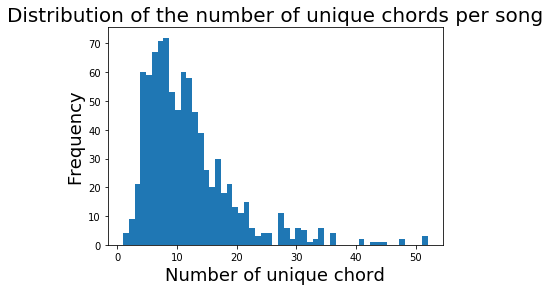

In [19]:
#Basic statistics: Number of unique chords per songs
unique_chord_songs = collection_df[[SONG_ID,CHORD]].drop_duplicates().groupby(SONG_ID).count()
n_bins = int(unique_chord_songs.max())+1
unique_chord_songs.plot.hist(bins = n_bins, legend = False)
plt.title('Distribution of the number of unique chords per song', fontsize = 20)
plt.xlabel('Number of unique chord', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.show()

# Milestone 3

## Squeezed dataframe

First, we define a function to obtain a dataframe with all the chords of a song squeezed in its various sections (intro, first verse, chorus, second verse...).

In [69]:
#The squeeze function returns a dataframe with the all the chords of a song squeezed in a row dependent on a subgroup
# of the section type. Default is "none" and will not filter any type of songs.
#try subgroup="chorus" or subgroup="verse"

def compress(s) :
    return s.dropna().to_list()

def squeeze(df,subgroup="none"):
    df_local=df
    if(subgroup!="none"):
        df_local=df[df["section_type"]==subgroup]
    
    chords = df_local.groupby(["song_id","title"]).chord.agg(compress).reset_index()[['song_id', 'chord']]
    roots = df_local.groupby(["song_id","title"]).root.agg(compress).reset_index()[['song_id', 'root']]
    shorthands = df_local.groupby(["song_id","title"]).shorthand.agg(compress).reset_index()[['song_id', 'shorthand']]
    
    return chords.merge(roots, on = 'song_id').merge(shorthands, on = 'song_id')

In [87]:
squeeze(collection_df).head()

,song_id,chord,root,shorthand
0,3,"[A:min, A:min, C:maj, C:maj, A:min, A:min, C:m...","[, A, A, C, C, A, A, C, C, A, A, C, C, A, A, C...","[nan, min, min, maj, maj, min, min, maj, maj, ..."
1,4,"[Ab:maj, Db:maj/5, Ab:maj, G:hdim7, C:7, F:min...","[, Ab, Db, Ab, G, C, F, C, C, F, C, F, C, F, F...","[nan, maj, maj, maj, hdim7, 7, min, 7, 7, min,..."
2,6,"[C:5, C:maj, G:maj/3, F:maj/3, F:maj/3, F:maj/...","[, C, C, G, F, F, F, G, C, C, G, F, F, F, G, C...","[nan, 5, maj, maj, maj, maj, maj, maj, maj, ma..."
3,10,"[C:maj, C:maj, C:maj, D:min, D:min, F:maj, G:m...","[, C, C, C, D, D, F, G, G, C, C, C, D, D, F, G...","[nan, maj, maj, maj, min, min, maj, maj, maj, ..."
4,12,"[E:min, F#:min, G:maj, A:maj, E:min, F#:min, G...","[, E, F#, G, A, E, F#, G, A, A, G, G, D, D, G,...","[nan, min, min, maj, maj, min, min, maj, maj, ..."


In [81]:
#squeeze section allows you to squeeze the sections of songs
def squeeze_section(df,subgroup="none"):
    df_local=df
    if(subgroup!="none"):
        df_local=df[df["section_type"]==subgroup]
    
    chords = df_local.groupby(["song_id","sequence_id","section_type"]).chord.agg(compress).reset_index()
    roots = df_local.groupby(["song_id","sequence_id","section_type"]).root.agg(compress).reset_index()
    shorthands = df_local.groupby(["song_id","sequence_id","section_type"]).shorthand.agg(compress).reset_index()
    
    return chords.merge(roots, on = ['song_id', 'sequence_id', 'section_type']).merge(shorthands, on = ['song_id', 'sequence_id', 'section_type'])

In [85]:
squeeze_section(collection_df).head()

,song_id,sequence_id,section_type,chord,root,shorthand
0,3,0,silence,[],[],[nan]
1,3,1,intro,"[A:min, A:min, C:maj, C:maj, A:min, A:min, C:m...","[A, A, C, C, A, A, C, C, A, A, C, C]","[min, min, maj, maj, min, min, maj, maj, min, ..."
2,3,2,verse,"[A:min, A:min, C:maj, C:maj, A:min, A:min, C:m...","[A, A, C, C, A, A, C, C, F, F, D, D, G, G, C, C]","[min, min, maj, maj, min, min, maj, maj, maj, ..."
3,3,3,verse,"[A:maj, A:maj, C:maj, C:maj, A:maj, A:maj, C:m...","[A, A, C, C, A, A, C, C, F, F, D, D, G, G, C, C]","[maj, maj, maj, maj, maj, maj, maj, maj, maj, ..."
4,3,4,interlude,"[A:min, A:min, C:maj, C:maj, A:min, A:min, C:m...","[A, A, C, C, A, A, C, C, F, F, D, D, G, G, C, C]","[min, min, maj, maj, min, min, maj, maj, maj, ..."


## Parser for the chords 

We also define a parser to better handle the chords. This is based on the notation defined in http://ismir2005.ismir.net/proceedings/1080.pdf. Some notations are also added by the authors of the dataset and therefore included to handle all the 989 unique chords in the dataset. 

In [24]:
print('There are %d unique chords in the dataset.' %len(collection_df.chord.unique()))

There are 978 unique chords in the dataset.


In [25]:
#Split a string and changes the target field depending on which side of the split to take
#side : 0 for left and 1 for right
def split_add(c,dic,split_char,target,side):
    temp=str.split(str(c),split_char)

    dic[target]=temp[side]
    return dic, temp[1-side]


def chord_to_tab(c):
    c=str(c)
    chord={"root":"", "shorthand" : "", "degree_list":[], "bass":"", "N" :False}
    rest=""
    
    if(c=="N"):
        chord["N"] = True
        return chord
    
    c=c.replace(")","")
    
    if('/' in c):
        chord, rest=split_add(c,dic=chord,split_char="/",target="bass",side=1)
    else :
        rest=c
    if(':' in rest):
        chord, rest=split_add(rest,dic=chord,split_char=":",target="root",side=0)
    if('(' in rest):
        chord, rest=split_add(rest,dic=chord,split_char="(",target="degree_list",side=1)
    if(rest != ""):
        chord["shorthand"]=rest
    
    return chord

    

In [26]:
collection_df['chord_dic'] = collection_df.chord.map(lambda y : chord_to_tab(y))
for key in ['root', 'shorthand', 'degree_list', 'bass', 'N']:
    collection_df[key] = collection_df.chord_dic.map(lambda y: y[key])
collection_df.drop(columns = 'chord_dic', inplace = True)
#df = collection_df[['song_id', 'title', 'artist', 'tonic', 'section_type', 'sequence_id', 'chord', 'root', 'shorthand', 'degree_list', 'bass', 'N']]

In [27]:
collection_df.head()

,song_id,title,artist,metre,tonic,line_id,time,section_type,sequence_id,section_structure,...,chord,duration,instrument,elided,repetition,root,shorthand,degree_list,bass,N
0,3,I Don't mind,James Brown,6/8,C,5,0.0,silence,0,NaN,...,NaN,NaN,NaN,NaN,NaN,,nan,[],,False
1,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,A:min,measure,NaN,NaN,NaN,A,min,[],,False
2,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,A:min,measure,NaN,NaN,NaN,A,min,[],,False
3,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,C:maj,measure,NaN,NaN,NaN,C,maj,[],,False
4,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,C:maj,measure,NaN,NaN,NaN,C,maj,[],,False


### Relative to tonic roots

Here we shift the roots relative to the tonic roots of each song. We also switch to the TPC representation.

In [46]:
TPC_DIC = {"Cb":11,"C":0,"C#":1,"Db":1,"D":2,"D#":3,"Eb":3,"E":4,"E#":5,"Fb":4,"F":5,"F#":6,
           "Gb":6,"G":7,"G#":8,"Ab":8,"A":9,"A#":10,"Bb":10,"B":11,"B#":0}

In [47]:
collection_df["root_tpc"] = collection_df.root.apply(lambda r : TPC_DIC.get(r))
collection_df = collection_df.astype({"root_tpc":"Int64"})

In [48]:
collection_df["relative_root_tpc"] =\
collection_df.apply(lambda row: (row["root_tpc"] - TPC_DIC.get(row["tonic"]))%12,axis = 1)

In [49]:
collection_df.head()

,song_id,title,artist,metre,tonic,line_id,time,section_type,sequence_id,section_structure,...,elided,repetition,root,shorthand,degree_list,bass,N,root_tpc,relative_root_tpc,n_succ_beats
0,3,I Don't mind,James Brown,6/8,C,5,0.0,silence,0,NaN,...,NaN,0,,nan,[],,False,NaN,NaN,0
1,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,NaN,0,A,min,[],,False,9,9.0,2
2,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,NaN,0,A,min,[],,False,9,9.0,2
3,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,NaN,0,C,maj,[],,False,0,0.0,2
4,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,NaN,0,C,maj,[],,False,0,0.0,2


### Duration tools

Duration of measure: all metre in the corpus are regular except song 700 (5/8 = 3 + 2). This was counted as two beats.

Creation of a one-row-per-beat dataframe (Need all cells of this section to work properly)

In [32]:
collection_df = collection_df.fillna({REPETITION:0})
collection_df = collection_df.fillna({REPETITION:0})

In [33]:
def weight_row(metre, duration, repetition):
    """
    Indicate to how many beats in total a chord described on a dataframe's row correspond.
    Careful ! The chords are non-successive in case of repetition
    """
    num, denom = metre.split("/")
    
    if metre == "5/8": #Specific to this dataset
        beat_per_measure = 2
    else:
        beat_per_measure = int(num)/(1 if int(denom) == 4 else 3)
    
    if duration == "measure":
        return beat_per_measure*(repetition+1)
    
    elif duration == "half-measure":
        return beat_per_measure/2*(repetition+1)
    
    elif duration == "beat":
        return repetition+1
    
    else:
        return 0

def successive_repetition_row(metre,duration):
    """
    Indicate on how many successive beats a chord is present
    """
    return weight_row(metre,duration,repetition=0)

#### Creation of one-row-per-bit dataframe

In [34]:
# Creation of one-row-per-bit dataframe
N_SUCC_BEATS = "n_succ_beats"

collection_df[N_SUCC_BEATS] = collection_df.apply(\
    lambda row: successive_repetition_row(row[METRE], row[DURATION]),axis=1)
collection_df = collection_df.astype({N_SUCC_BEATS:"Int64"})

In [66]:
from tqdm import tqdm
beats_dics = []
for i in tqdm(collection_df.index):
    for b in range(collection_df.iloc[i][N_SUCC_BEATS]):
        beats_dics.append(collection_df.iloc[i].to_dict())
        
b_collection_df = pd.DataFrame(beats_dics)

100%|████████████████████████████████████████████████████████████████████████| 128684/128684 [01:10<00:00, 1835.14it/s]


In [67]:
b_collection_df = b_collection_df.drop(N_SUCC_BEATS,axis=1)

### Chorus/verse proportion

We consider the distribution of the proportion of beats in a song that belong to choruses, respectively to verses.

In [71]:
TOTAL_WEIGHT = "total_weight"

collection_df[TOTAL_WEIGHT] = collection_df.apply(\
    lambda row: weight_row(row[METRE], row[DURATION], row[REPETITION]),axis=1)

collection_df[N_SUCC_BEATS] =  collection_df.apply(\
    lambda row: successive_repetition_row(row[METRE], row[DURATION]),axis=1)

collection_df = collection_df.astype({TOTAL_WEIGHT: 'Int64',N_SUCC_BEATS: 'Int64'})

In [72]:
n_beat_chorus = collection_df[collection_df.section_type == "chorus"].groupby("song_id")[TOTAL_WEIGHT].sum()\
.reset_index().rename(columns= {TOTAL_WEIGHT:"chorus_weight"})
n_beat_verse = collection_df[collection_df.section_type == "verse"].groupby("song_id")[TOTAL_WEIGHT].sum()\
.reset_index().rename(columns= {TOTAL_WEIGHT:"verse_weight"})
n_beat = collection_df.groupby("song_id")[TOTAL_WEIGHT].sum()

#Considering only songs with both chorus and verse. For all song, use line below
# n_beat_chorus.merge(n_beat_verse,on="song_id",how="outer").merge(n_beat,on="song_id",how="outer").fillna(0)
proportions_df = n_beat_chorus.merge(n_beat_verse,on="song_id").merge(n_beat,on="song_id")

proportions_df["chorus_weight"] = proportions_df["chorus_weight"]/proportions_df["total_weight"]
proportions_df["verse_weight"] = proportions_df["verse_weight"]/proportions_df["total_weight"]

In [73]:
proportions_df[["chorus_weight","verse_weight"]].describe().drop("count")

,chorus_weight,verse_weight
mean,0.324155,0.323251
std,0.123022,0.129199
min,0.065934,0.055556
25%,0.238806,0.228571
50%,0.323810,0.313725
75%,0.400000,0.402216
max,0.804878,0.754717


What we can observe is that the distributions of choruses and verses share similar statistics.

### Creation of a dataframe with only songs that have both a verse and a chorus

Since we want to compare verses and choruses, and sometimes in particular their differences within each song, we will only keep songs that have both at least a verse and at least a chorus.

In [78]:
valid_songs = collection_df[[SONG_ID,TYPE]].drop_duplicates().groupby(SONG_ID)[TYPE].apply(list)\
.apply(lambda l: "chorus" in l and "verse" in l)

In [83]:
df = collection_df.merge(valid_songs.reset_index().rename(columns = {TYPE:"valid"}), on = SONG_ID)
df = df[df.valid].drop(columns = ['valid', 'instrument', 'elided']) #We drop columns that we don't need anymore, for ease of clarity

In [87]:
df.head()

,song_id,title,artist,metre,tonic,line_id,time,section_type,sequence_id,section_structure,measure_id,chord_id,chord,duration,repetition,n_succ_beats,total_weight
88,4,You've got a Friend,Roberta Flack and Donny Hathaway,4/4,Ab,5,0.000000000,silence,0,NaN,NaN,NaN,NaN,NaN,0,0,0
89,4,You've got a Friend,Roberta Flack and Donny Hathaway,4/4,Ab,6,0.255419501,intro,1,A,0,0,Ab:maj,measure,0,4,4
90,4,You've got a Friend,Roberta Flack and Donny Hathaway,4/4,Ab,6,0.255419501,intro,1,A,1,1,Db:maj/5,measure,0,4,4
91,4,You've got a Friend,Roberta Flack and Donny Hathaway,4/4,Ab,6,0.255419501,intro,1,A,2,2,Ab:maj,measure,0,4,4
92,4,You've got a Friend,Roberta Flack and Donny Hathaway,4/4,Ab,6,0.255419501,intro,1,A,3,3,G:hdim7,half-measure,0,2,2


### Tonic Proportion

## Chord distribution

We can now analyse the distribution of chords (or elements of it such as the root or the quality) in the songs and in specific sections such as the verse and the chorus.

<div style="border:3px solid black; padding:10px 10px; background-color: #3388FF; text-align: center; font-size:20px;"> 
    <strong>Most common chords used</strong>
</div> 

We can start by finding the most used chords in a given section. By default we look at the 50 most common chords.

In [82]:
def chord_distribution(section = 'verse', top = 50):
    title = 'Chord distribution in the ' + section
    plt.figure(figsize = (16,6))
    collection_df[collection_df.section_type == section].chord.value_counts().iloc[:top].plot(kind='bar')
    plt.title(title, fontsize = 20)
    plt.xlabel('Chord', fontsize = 18)
    plt.xticks(rotation = 50)
    plt.ylabel('Number of chords', fontsize = 18)

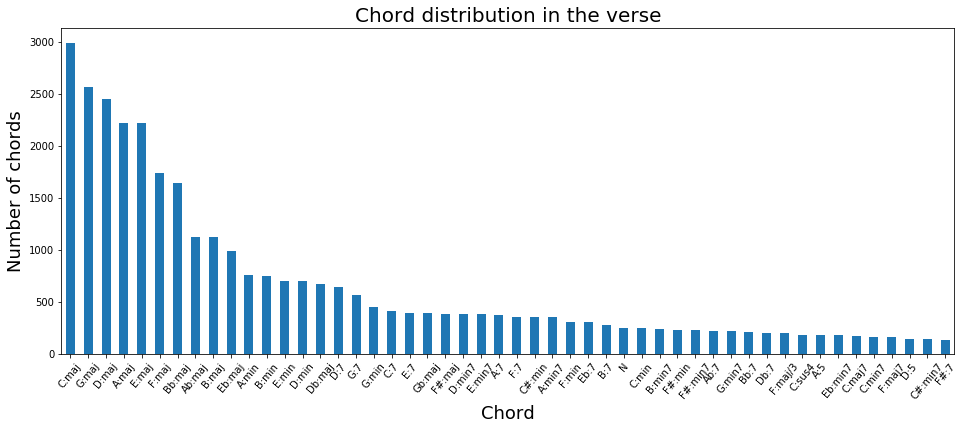

In [83]:
chord_distribution('verse')

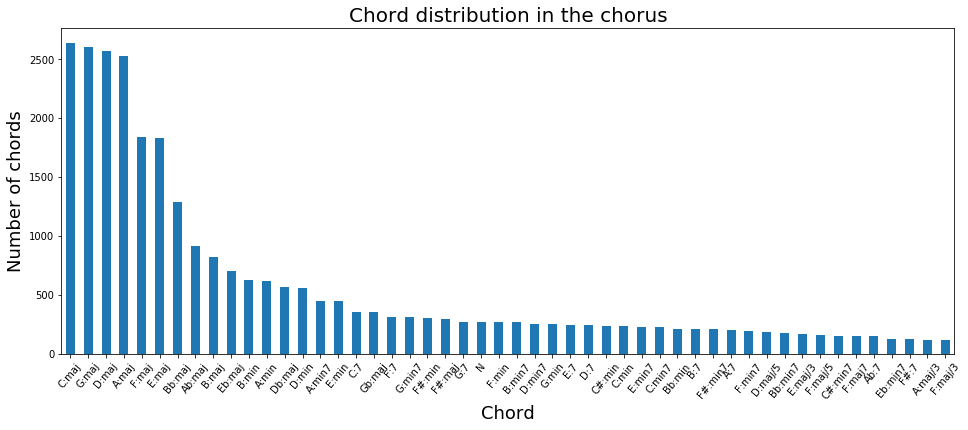

In [84]:
chord_distribution('chorus')

<div style="border:3px solid black; padding:10px 10px; background-color: #3388FF; text-align: center; font-size:20px;"> 
    <strong>Distribution of unique chords</strong>
</div> 

We can also look at the distribution of unique chords used in songs.

In [34]:
def GetUniqueChords(df):
    return df.groupby('song_id').chord.unique().map(lambda x: len(x))

In [35]:
def unique_chords_section(section = 'verse'):
    unique_chords = GetUniqueChords(df[df.section_type == section])
    n_bins = int(unique_chords.max()) + 1
    unique_chords.plot.hist(bins = n_bins, legend = False)
    title = 'Distribution of the number of unique chords per song in the ' + section
    plt.title(title, fontsize = 20)
    plt.xlabel('Number of unique chords used', fontsize = 18)
    plt.ylabel('Frequency', fontsize = 18)
    plt.show()
    
    print('Statistics:')
    print(unique_chords.describe())
    
    return (unique_chords.describe()['mean'], unique_chords.describe()['std']/np.sqrt(unique_chords.describe()['count']))

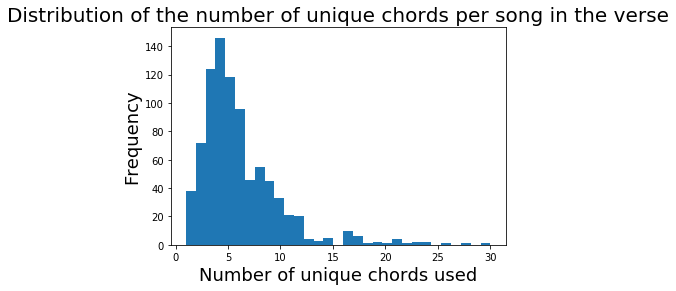

Statistics:
count    858.000000
mean       5.900932
std        3.953431
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       30.000000
Name: chord, dtype: float64


In [36]:
stats_verse = unique_chords_section('verse')

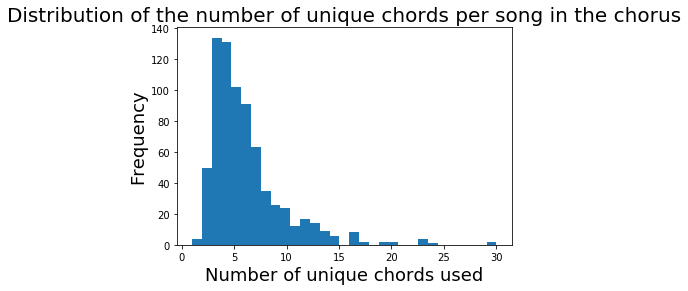

Statistics:
count    739.000000
mean       5.995940
std        3.792909
min        1.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       30.000000
Name: chord, dtype: float64


In [37]:
stats_chorus = unique_chords_section('chorus')

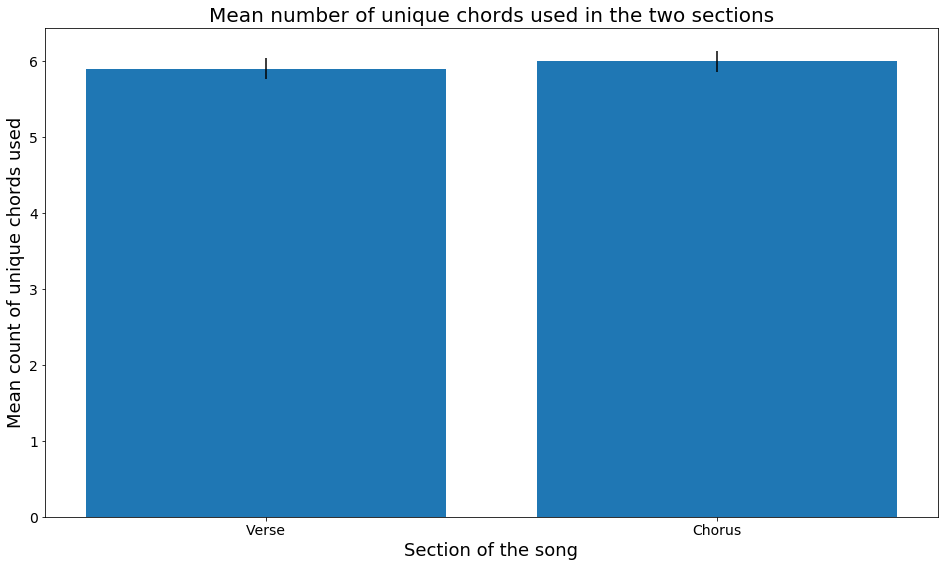

In [38]:
plt.figure(figsize = (16,9))
plt.bar(x = [0, 1], height = [stats_verse[0], stats_chorus[0]], yerr = [stats_verse[1], stats_chorus[1]])
plt.xticks([0,1], ['Verse', 'Chorus'], fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Mean number of unique chords used in the two sections', fontsize = 20)
plt.xlabel('Section of the song', fontsize = 18)
plt.ylabel('Mean count of unique chords used', fontsize = 18)
plt.show()

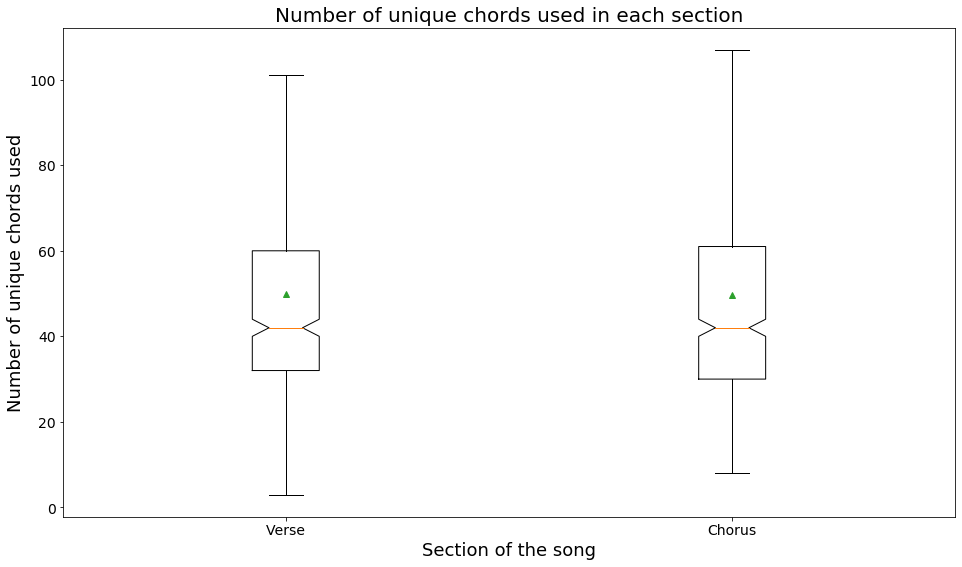

In [70]:
data = [df[df.section_type == 'verse'].groupby(SONG_ID).count().title,
        df[df.section_type == 'chorus'].groupby(SONG_ID).count().title]
plt.figure(figsize = (16,9))
plt.boxplot(data, notch = True, 
                  bootstrap = 5000, 
                  showfliers = False, #Don't show outliers to better compare medians between the two sections
                  showmeans = True)
plt.title('Number of unique chords used in each section', fontsize = 20)
plt.xticks([1,2], ['Verse', 'Chorus'], fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Section of the song', fontsize = 18)
plt.ylabel('Number of unique chords used', fontsize = 18)
plt.show()

Finally, we'll use statistical tests to find if the differences observed are significant. From the previous plots, we can already expect to not have significant differences here.

In [72]:
from scipy import stats
import researchpy as rp

We will run an independent t-test to check if the two sample data, i.e. the number of unique chords used in the verse and in the chorus sections of the songs, are the same or not. But first we need to check the independent t-test assumptions:
   * homogeneity of variances (with the Levene's test)
   * normal distributions of redisuals (with Shapiro-Wilk's test)

In [75]:
stats.levene(data[0], data[1])

LeveneResult(statistic=0.028776639079050235, pvalue=0.8653173027742126)

In [76]:
stats.shapiro(data[0] - data[1]) #Need to have the same size, ie only keep songs with both a chorus & a verse

(nan, 1.0)

Since both assumptions are met (both p-values are larger than 0.05, meaning the sample data do not violate the assumptions), we can proceed with the independent t-test. Let's start by having a quick look at some basic statistics (where the first line is for verse, the second for chorus and the third for the combined data). As already seen with the plots, means and SDs are nearly the same.

In [80]:
descriptives, results = rp.ttest(data[0], data[1])
descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,title,858.0,49.948718,33.518899,1.144316,47.702727,52.194709
1,title,739.0,49.631935,33.286672,1.224470,47.228076,52.035795
2,combined,1597.0,49.802129,33.401554,0.835823,48.162703,51.441555


In [81]:
results

,Independent t-test,results
0,Difference (title - title) =,0.3168
1,Degrees of freedom =,1595.0000
2,t =,0.1889
3,Two side test p value =,0.8502
4,Difference < 0 p value =,0.5749
5,Difference > 0 p value =,0.4251
6,Cohen's d =,0.0095
7,Hedge's g =,0.0095
8,Glass's delta =,0.0095
9,r =,0.0047


As expected, the two sample data do not violate the null hypothesis because p-value=0.8502 > 0.05 (i.e. there are no significant differences).

<div style="border:3px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion:</strong> the distribution of the number of unique chords used in each section has ben investigated. For both verse and chorus sections, the distribution is right skewed with a mean slighly under 6 unique chords used and a tail with maximum values reaching up to 30 unique chords used. An independent t-test has been conducted to find if the differences are statistically significant. As expected, results (t[1595]=0.1889, p-value=0.8502 > 0.5) show that the two sample data do not violate the null hypothesis (i.e. the two distributions are similar). 
</div>

<div style="border:3px solid black; padding:10px 10px; background-color: #3388FF; text-align: center; font-size:20px;"> 
    <strong>Root of the chords</strong>
</div> 

Now we can look at the roots of the chords, first on the whole songs and then on each section.

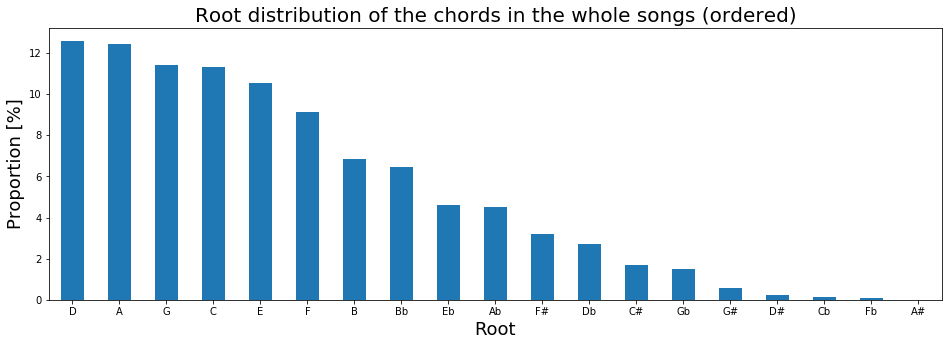

In [50]:
root_dist = collection_df.root.value_counts()
#We remove the missing values (marked with an empty space by our parser)
root_dist.drop('', inplace = True)
#Plot
plt.figure(figsize = (16,5))
root_dist.map(lambda x: 100 * x / root_dist.sum()).plot(kind = 'bar')
plt.title('Root distribution of the chords in the whole songs (ordered)', fontsize = 20)
plt.xlabel('Root', fontsize = 18)
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportion [%]', fontsize = 18)
plt.show()

We can also move to the line of fifths representation to check if we get the characteristic bell shape.

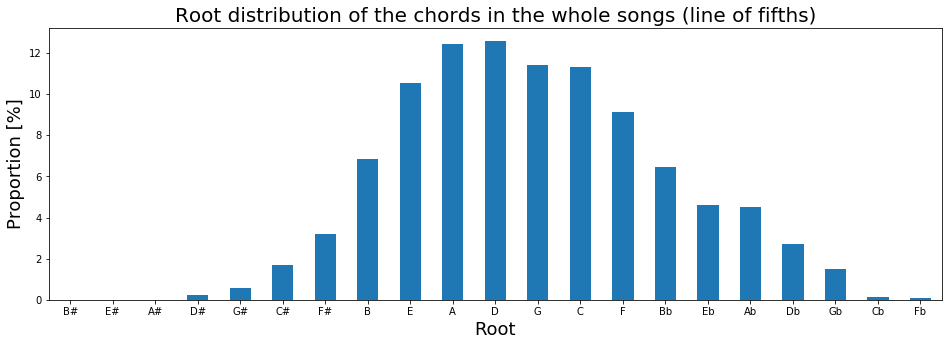

In [51]:
root_dist = collection_df.root.value_counts()
#Let's move to the line of fifths
fifths_line = ['B#', 'E#', 'A#', 'D#', 'G#', 'C#', 'F#', 
               'B', 'E', 'A', 'D', 'G', 'C', 'F', 
               'Bb', 'Eb', 'Ab', 'Db', 'Gb', 'Cb', 'Fb']
root_dist = pd.Series(index = fifths_line, data = root_dist).fillna(0)
#Plot
plt.figure(figsize = (16,5))
root_dist.map(lambda x: 100 * x / root_dist.sum()).plot(kind = 'bar')
plt.title('Root distribution of the chords in the whole songs (line of fifths)', fontsize = 20)
plt.xlabel('Root', fontsize = 18)
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportion [%]', fontsize = 18)
plt.show()

In [98]:
def root_distribution_section(section = 'verse', index = 1, fifths = True):
    root_dist = df[df.section_type == section].root.value_counts()
    if fifths:
        root_dist = pd.Series(index = fifths_line, data = root_dist).fillna(0)
    else:
        #We remove the non-roots notation elements
        if '' in root_dist.index:
            root_dist.drop('', inplace = True) 

    #Plot
    plt.figure(figsize = (16,9))
    plt.subplot(2, 1, index)
    root_dist.map(lambda x: 100 * x / root_dist.sum()).plot(kind = 'bar')
    title = 'Root distribution of the chords in the ' + section
    if fifths:
        title += '(line of fifths)'
    else:
        title += '(ordered)'
    plt.title(title, fontsize = 20)
    plt.xlabel('Root', fontsize = 18)
    plt.xticks(rotation = 'horizontal')
    plt.ylabel('Proportion [%]', fontsize = 18)
    plt.show()

Let's first plot the results on a normal scale from the most used to the least used roots.

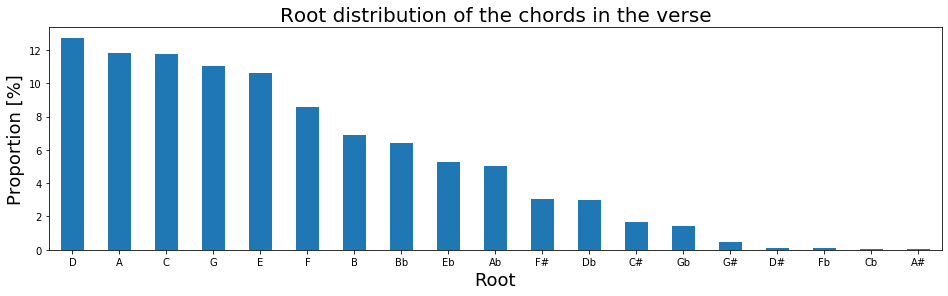

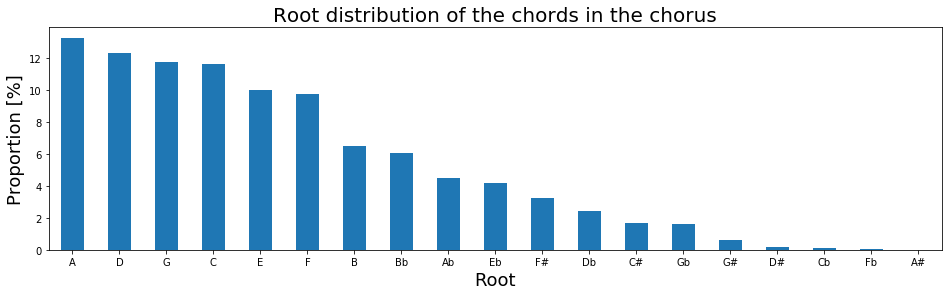

In [106]:
root_distribution_section('verse', 1, False)
root_distribution_section('chorus', 2, False)

And then using again the line of fifths.

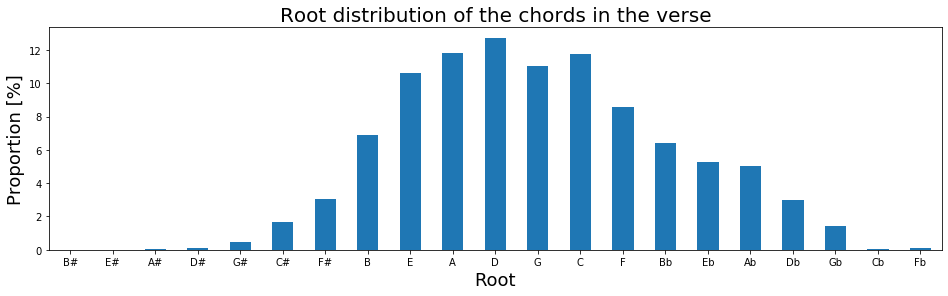

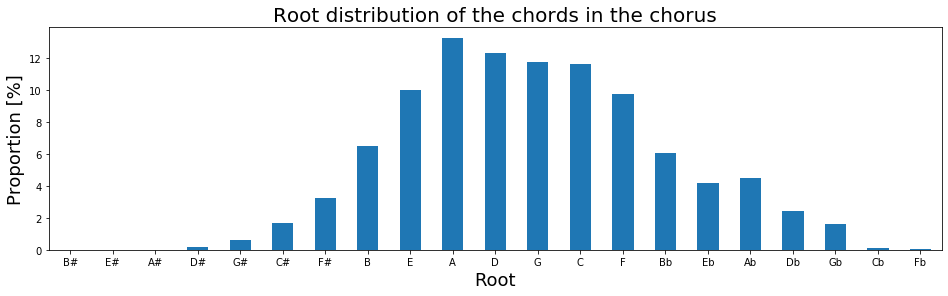

In [99]:
root_distribution_section('verse', 1)
root_distribution_section('chorus', 2)

<div style="border:3px solid black; padding:10px 10px; background-color: #3388FF; text-align: center; font-size:20px;"> 
    <strong>Quality of the chords</strong>
</div> 

Next we can investigate the quality (or type) of the chords, using the parser previously defined.

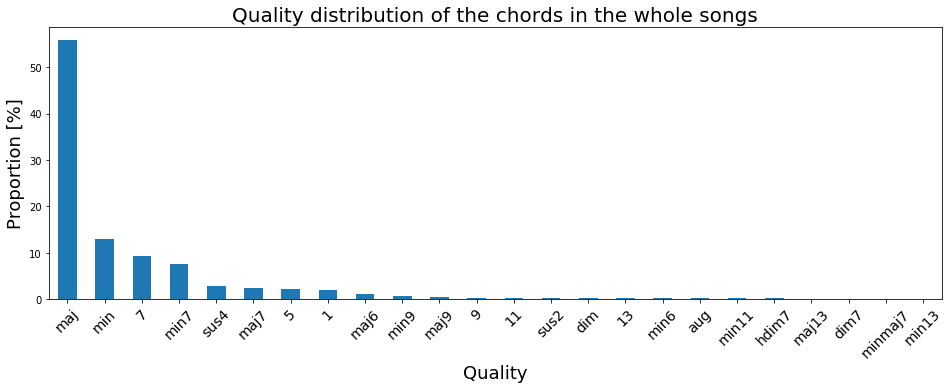

In [107]:
quality_dist = df.shorthand.value_counts()
#We remove the missing values (marked with an empty space by our parser)
quality_dist.drop(['nan', '', '*', '&pause'], inplace = True)
#Plot
plt.figure(figsize = (16,5))
quality_dist.map(lambda x: 100 * x / quality_dist.sum()).plot(kind = 'bar')
plt.title('Quality distribution of the chords in the whole songs', fontsize = 20)
plt.xlabel('Quality', fontsize = 18)
plt.xticks(rotation = 45, fontsize = 14)
plt.ylabel('Proportion [%]', fontsize = 18)
plt.show()

In [110]:
def quality_distribution_section(section = 'verse'):
    quality_dist = df[df.section_type == section].shorthand.value_counts()
    #We remove the non-roots notation elements
    extra_notations = ['nan', '', '*', '&pause']
    for notation in extra_notations:
        if notation in quality_dist.index:
            quality_dist.drop(notation, inplace = True) 

    #Plot
    plt.figure(figsize = (16,9))
    plt.subplot(2, 1, 1)
    quality_dist.map(lambda x: 100 * x / quality_dist.sum()).plot(kind = 'bar')
    title = 'Quality distribution of the chords in the ' + section
    plt.title(title, fontsize = 20)
    plt.xlabel('Quality', fontsize = 18)
    plt.xticks(rotation = 45, fontsize = 14)
    plt.ylabel('Proportion [%]', fontsize = 18)
    plt.show()

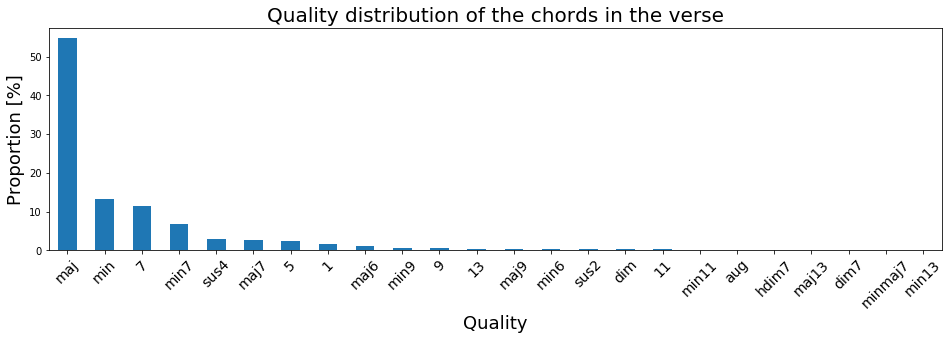

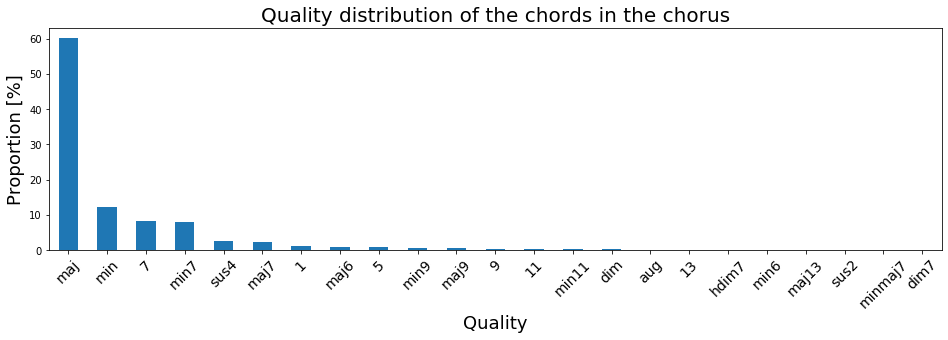

In [111]:
quality_distribution_section('verse')
quality_distribution_section('chorus')

We observe that major chords are the most used by a large margin. Then come in a close range minor, seventh and minor seventh chords. All other chords have much lower frequencies of usage in both verse and chorus sections. Let's compare the mean proportion of these four predominants chord qualities between the two sections.

In [46]:
def GetCountsOfQuality(section, quality):
    return df[df.section_type == section][df.shorthand == quality].groupby('song_id').count().title

C:\Users\giaco\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



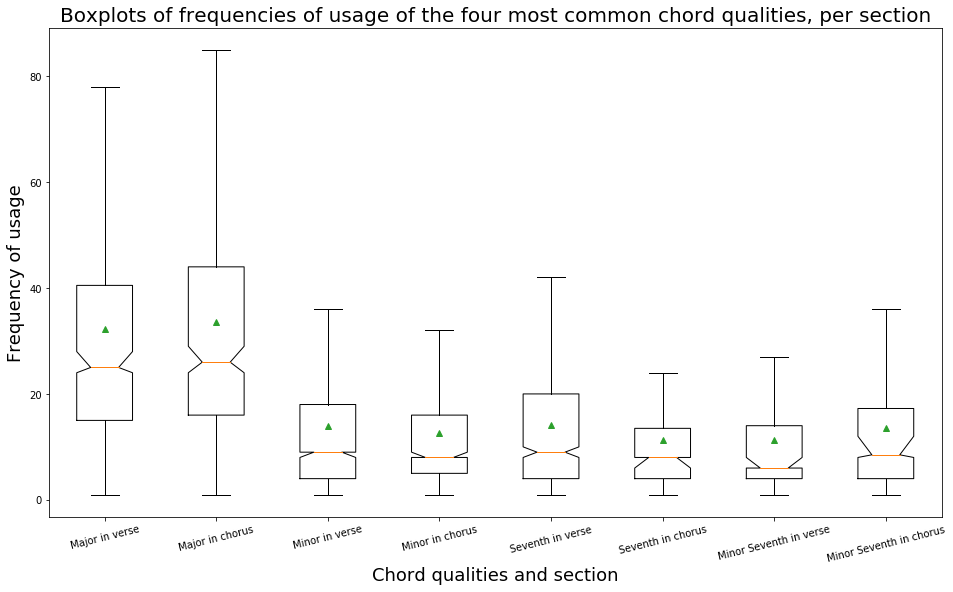

In [113]:
labels = ['Major in verse', 'Major in chorus',
          'Minor in verse', 'Minor in chorus',
          'Seventh in verse', 'Seventh in chorus',
          'Minor Seventh in verse', 'Minor Seventh in chorus']
data = [GetCountsOfQuality('verse', 'maj'), 
        GetCountsOfQuality('chorus', 'maj'),
        GetCountsOfQuality('verse', 'min'),
        GetCountsOfQuality('chorus', 'min'),
        GetCountsOfQuality('verse', '7'),
        GetCountsOfQuality('chorus', '7'),
        GetCountsOfQuality('verse', 'min7'),
        GetCountsOfQuality('chorus', 'min7')]
plt.figure(figsize = (16, 9))
plt.boxplot(data,
            notch = True,
            bootstrap = 5000,
            showfliers = False, #Don't show outliers to better compare medians between the two sections
            showmeans = True)
plt.xticks(range(1,9), labels, rotation = 14)
plt.title('Boxplots of frequencies of usage of the four most common chord qualities, per section', fontsize = 20)
plt.xlabel('Chord qualities and section', fontsize = 18)
plt.ylabel('Frequency of usage', fontsize = 18)
plt.show()

<div style="border:3px solid black; padding:10px 10px; background-color: #3388FF; text-align: center; font-size:20px;"> 
    <strong>Bass note of the chords</strong>
</div> 

Finally, the third element of a chord that we can observe is the bass note used (or the lack of it, in most cases).

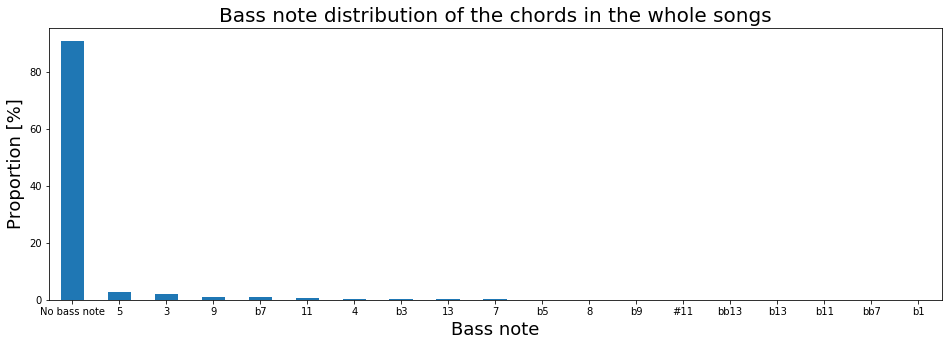

In [48]:
bass_note_dist = df.bass.value_counts().rename({'':'No bass note'})
#Plot
plt.figure(figsize = (16,5))
bass_note_dist.map(lambda x: 100 * x / bass_note_dist.sum()).plot(kind = 'bar')
plt.title('Bass note distribution of the chords in the whole songs', fontsize = 20)
plt.xlabel('Bass note', fontsize = 18)
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportion [%]', fontsize = 18)
plt.show()

As we can see, most chords do not use a bass note. We will therefore exclude this case in order to better observe which notes are more commonly used as bass notes.

In [49]:
def bassnote_distribution_section(section = 'verse'):
    bass_note_dist = df[df.section_type == section].bass.value_counts()
    #We remove the non-roots notation elements
    if '' in bass_note_dist.index:
        bass_note_dist.drop('', inplace = True) 

    #Plot
    plt.figure(figsize = (16,9))
    plt.subplot(2, 1, 1)
    bass_note_dist.map(lambda x: 100 * x / bass_note_dist.sum()).plot(kind = 'bar')
    title = 'Bass note distribution of the chords in the ' + section
    plt.title(title, fontsize = 20)
    plt.xlabel('Bass note', fontsize = 18)
    plt.xticks(rotation = 'horizontal')
    plt.ylabel('Proportion [%]', fontsize = 18)
    plt.show()

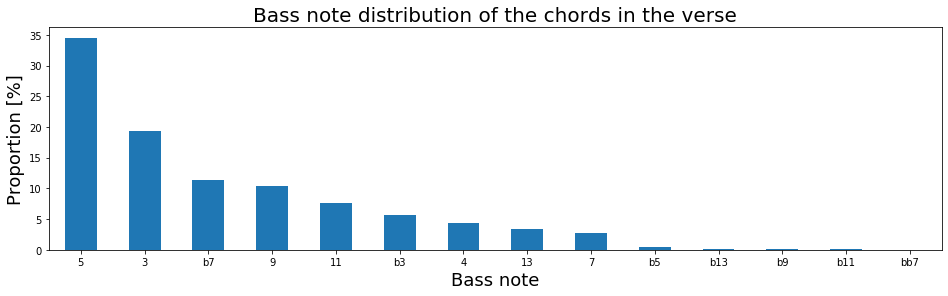

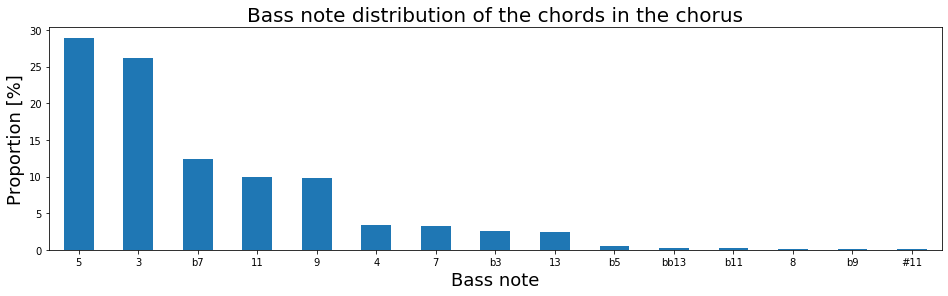

In [50]:
bassnote_distribution_section('verse')
bassnote_distribution_section('chorus')

As we did for chord qualities, we will investigate more in depth the frequencies of usage of the most common bass notes, in this case note 5 and note 3.

In [51]:
def GetCountsOfBassNote(section, bass_note):
    return df[df.section_type == section][df.bass == bass_note].groupby('song_id').count().title

C:\Users\giaco\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



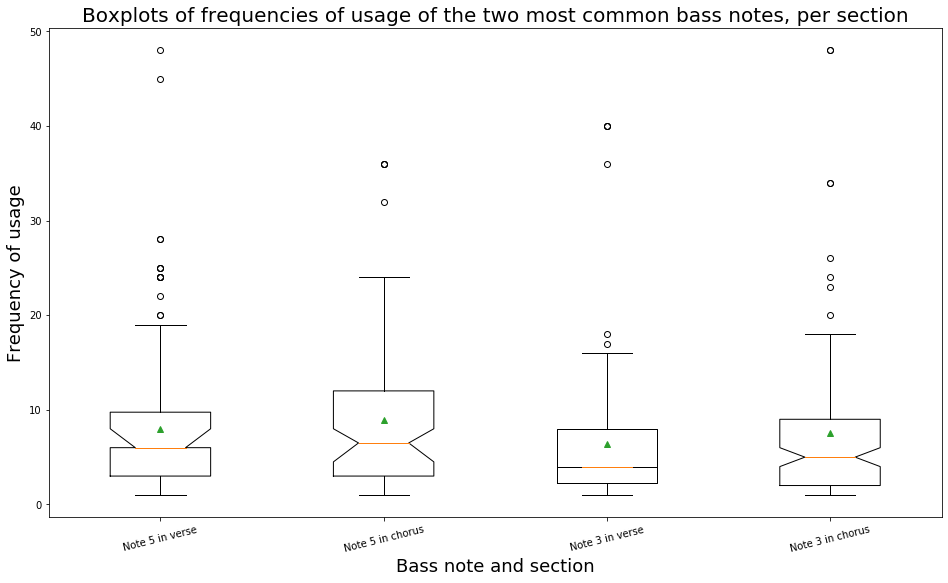

In [52]:
labels = ['Note 5 in verse', 'Note 5 in chorus',
          'Note 3 in verse', 'Note 3 in chorus']
data = [GetCountsOfBassNote('verse', '5'), 
        GetCountsOfBassNote('chorus', '5'),
        GetCountsOfBassNote('verse', '3'),
        GetCountsOfBassNote('chorus', '3')]
plt.figure(figsize = (16, 9))
plt.boxplot(data,
            notch = True,
            bootstrap = 5000,
            showfliers = True, #Here the outliers do not skew too much the boxplots
            showmeans = True)
plt.xticks(range(1,5), labels, rotation = 14)
plt.title('Boxplots of frequencies of usage of the two most common bass notes, per section', fontsize = 20)
plt.xlabel('Bass note and section', fontsize = 18)
plt.ylabel('Frequency of usage', fontsize = 18)
plt.show()

<div style="border:3px solid black; padding:10px 10px; background-color: #3388FF; text-align: center; font-size:20px;"> 
    <strong>BoW representation</strong>
</div> 

Let's start by creating a function to compute the Bag of Words representation of each song (or part of a song). In this case, the words will be all the possible chords.

In [53]:
vocab = dict.fromkeys(df.chord.unique(), 0) #Need to remove non-chord elements

In [54]:
def createBOW(chord_list):
    bow = vocab
    for chord in chord_list:
        if chord in vocab.keys():
            bow[chord] += 1
    #Normalise the BoW to get a distribution
    total = sum(bow.values())
    bow = {chord: count/total for chord, count in bow.items()}
    return np.array(list(bow.values()))

We can then start to compute the BoW representation of the whole songs, using the function squeeze() previously created to help us.

In [55]:
df_bow = squeeze(collection_df)
df_bow['bow'] = df_bow.chord.map(lambda x: createBOW(x))

In [116]:
df_bow.head()

,song_id,title,chord,bow
0,3,I Don't mind,"[A:min, A:min, C:maj, C:maj, A:min, A:min, C:m...","[0.0, 0.2235294117647059, 0.4, 0.0941176470588..."
1,4,You've got a Friend,"[Ab:maj, Db:maj/5, Ab:maj, G:hdim7, C:7, F:min...","[0.0, 0.10919540229885058, 0.19540229885057472..."
2,6,The Rose,"[C:5, C:maj, G:maj/3, F:maj/3, F:maj/3, F:maj/...","[0.0, 0.07335907335907337, 0.1776061776061776,..."
3,10,An Innocent Man,"[C:maj, C:maj, C:maj, D:min, D:min, F:maj, G:m...","[0.0, 0.040169133192389, 0.2452431289640592, 0..."
4,12,Lookin' for Love,"[E:min, F#:min, G:maj, A:maj, E:min, F#:min, G...","[0.0, 0.03161397670549085, 0.1930116472545757,..."


Let's check each bow value is indeed a distribution (ie the sum of the elements is 1).

In [57]:
df_bow.bow.map(lambda x: sum(x)).sort_values()

718    1.0
508    1.0
648    1.0
472    1.0
591    1.0
      ... 
876    1.0
659    1.0
538    1.0
555    1.0
730    1.0
Name: bow, Length: 890, dtype: float64

We will do the same for the chorus and the verse section of songs.

In [58]:
df_bow_verse = squeeze(collection_df, 'verse')
df_bow_verse['bow'] = df_bow_verse.chord.map(lambda x: createBOW(x))

In [59]:
df_bow_verse.head()

,song_id,title,chord,bow
0,3,I Don't mind,"[A:min, A:min, C:maj, C:maj, A:min, A:min, C:m...","[0.0, 0.01732976311777762, 0.0659068110550303,..."
1,4,You've got a Friend,"[F:min, C:7/5, C:7, F:min, C:7/5, F:min/b3, C:...","[0.0, 0.01732798382510899, 0.0659000442282176,..."
2,6,The Rose,"[C:maj, G:maj/3, F:maj/3, F:maj/3, F:maj/3, G:...","[0.0, 0.017316495659037097, 0.0659510655090765..."
3,10,An Innocent Man,"[C:maj, C:maj, D:min, D:min, F:maj, G:maj, G:m...","[0.0, 0.017305978213713845, 0.0661239814792904..."
4,12,Lookin' for Love,"[G:maj, G:maj, D:maj, D:maj, G:maj, D:maj, A:m...","[0.0, 0.017301065348189853, 0.0661052100336716..."


In [60]:
df_bow_chorus = squeeze(collection_df, 'chorus')
df_bow_chorus['bow'] = df_bow_chorus.chord.map(lambda x: createBOW(x))

In [61]:
df_bow_chorus.head()

,song_id,title,chord,bow
0,4,You've got a Friend,"[Ab:maj, Ab:7, Db:maj, Db:maj, Ab:maj, Ab:maj,...","[0.0, 0.017409470752089137, 0.066746140408857,..."
1,10,An Innocent Man,"[C:maj, C:maj, F:maj/5, C:maj, C:maj, F:maj/3,...","[0.0, 0.017397355601948505, 0.0669355885024120..."
2,12,Lookin' for Love,"[D:maj, D:maj, F#:min, F#:min, G:maj, G:maj, E...","[0.0, 0.017390689201855793, 0.0669099398105299..."
3,16,She Bop,"[D:min, D:min, C:maj, F:maj, G:maj, E:7, A:min...","[0.0, 0.017491233756666766, 0.0669240062468692..."
4,18,Kiss On My List,"[C:maj, G:maj/11, A:min/b3, G:maj/11, C:min7, ...","[0.0, 0.017488141884924726, 0.0669652063753940..."


### Mean distance

In [62]:
from scipy.spatial import distance

In [63]:
def ComputeMeanDistance(df):
    dist_sum = 0
    count = 0
    for i in range(len(df)):
        for j in range(i):
                dist_sum += distance.euclidean(df.bow.iloc[i], df.bow.iloc[j])
                count += 1
    return dist_sum / count                

In [64]:
ComputeMeanDistance(df_bow)

0.03533654855883703

In [65]:
ComputeMeanDistance(df_bow_verse)

0.002744837976163625

In [66]:
ComputeMeanDistance(df_bow_chorus)

0.0024435512357438823

## Markov exploration

In [32]:
from collections import Counter

In [121]:
###### Circle of fifth

fifth=["F","C","G","D","A","E","B"]
big_fifth=["F","C","G","D","A","E","B"]

for i in range(0,len(fifth)) :
    
    big_fifth.append(fifth[i]+"#")
    big_fifth.insert(i,fifth[i]+"b")
    
######
# Compute bigrams

def bigrams_seq(seq):
    l=list(zip(seq[:-1], seq[1:]))
    return l


def bigrams_corpus(seqs):
    return [bg for seq in seqs for bg in bigrams_seq(seq)]


def markov_heatmap(bigram_seq, order=big_fifth, display_N=False, hide_diag=False) :
    """Take as intput a sequence of bigram in a counter type element and returns a heatmap
    order : display the axis in the given order, default is the circle of fifth
    display_N: allows you to display the silences as well noted ""
    hide_diag: don't display identical bigrams if true, default is False """
    #test_count=Counter(bigram_seq)
    test_count=bigram_seq
    
    if(order=='none'):
        x1s    = [ x1  for ((x1, x2), count) in test_count.items() ]
        x2s    = [ x2  for ((x1, x2), count) in test_count.items() ]
        y=pd.Series(x2s).drop_duplicates().sort_values()
        x=pd.Series(x1s).drop_duplicates().sort_values(ascending=False)
    else:
        if(display_N == False):
            y=order
            x=reversed(order)
            #x=order
            
    #df_local=df_store
    df_local=pd.DataFrame(index=x,columns=y)
    
    #if(display_N==False):
        #df_local=df_local.drop(index='')
        #df_local=df_local.drop(columns='')
    
    for ((x1, x2), count) in test_count.items():
        if(x1 != "" and x2 != ""):
            df_local[x1][x2]=count
            if(x1==x2 and hide_diag):
                df_local[x1][x2]=0
        elif(display_N==True):
            df_local[x1][x2]=count

            

    df_local=df_local.fillna(0)
    plt.figure(figsize=(7,7))
    #print(df_local)
    #return df_local
    sns.heatmap(data=df_local,cmap="coolwarm")

In [138]:
def substract_counts(c1,c2):
    """returns the substracted counters c1-c2"""
    c=Counter()
    for ((x1,x2),count) in c1.items() :
        c[(x1,x2)]=c1[(x1,x2)]-c2[(x1,x2)]
    return c    
    
    
def add_count(y,count):
    count+=Counter(y)
    return
    
    
def top_transition(c, n = 15, remove_equal = True, position = "head"):   
    """Plots the graph of the n most significant transition
    c: counter element.
    n: Number of elements to display 
    remove_equal: If True removes the transitions of two identical element
    position: Gives the head or tail elements"""
    
    for ((x1,x2),count) in c.items() :
        if(x1==x2 and remove_equal):
               c[(x1,x2)]=0
    
    x1s = [ (x1,x2)  for ((x1, x2), count) in c.items() ]
    values = [ count  for ((x1, x2), count) in c.items() ]
    
    
    df=pd.DataFrame(data=values, index=x1s)
    df=df.reset_index().set_index(0).sort_index(ascending=False).reset_index().set_index('index')
    df=df.rename(columns={0:"%"},index={"index":"bigrams"})
    
    #Plot
    title = 'Most frequent transitions'
    if(position != "tail"):
        df.head(n).plot(kind='bar', legend = False, figsize = (16,6))
    else:
        df.tail(n).plot(kind='bar', legend = False, figsize = (16,6))
        title += ' (tail)'
    plt.title(title, fontsize = 20)
    plt.xticks(rotation = 45, fontsize = 12)
    plt.xlabel('Transitions', fontsize = 18)
    plt.ylabel('Occurences [%]', fontsize = 18)
    plt.show()
    
    return 
    
    
def normalize_counter(c, remove_equal=True):
    
    tot=0
    for ((x1,x2),count) in c.items() :
        if(remove_equal and x1==x2 ):
            tot+=0
        else :
            tot+=count
    
        
    if(tot==0):
        return "error : empty counter"
    
    for ((x1,x2),count) in c.items() :
        c[(x1,x2)]=(c[(x1,x2)]*100)/tot
    return
        
    
    
def count_bigrams(df, chord_representation = 'chord', subsection='none', normalize=False):
    """Counts the bigrams of a given given data frame "df" grouped relative to the subsection.
    if normalize is true the output will be normalized (useful for comparing results)"""
    
    df = squeeze(df, subsection)
    
    df["bigrams"] = df[chord_representation].map(lambda y : bigrams_seq(y))
    c = Counter()
   
    df.bigrams.map(lambda y: add_count(y,c))
    if(normalize):
        normalize_counter(c)
        
    return c 

### Markov Model with the chords

#### Verse:

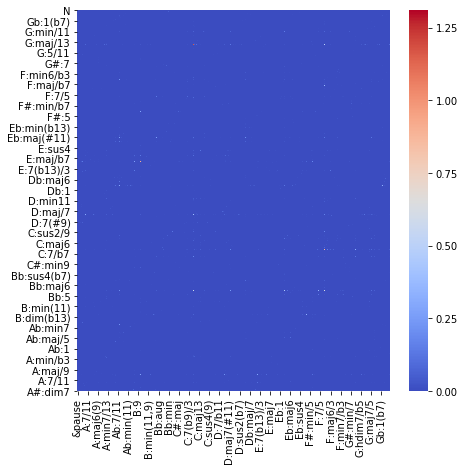

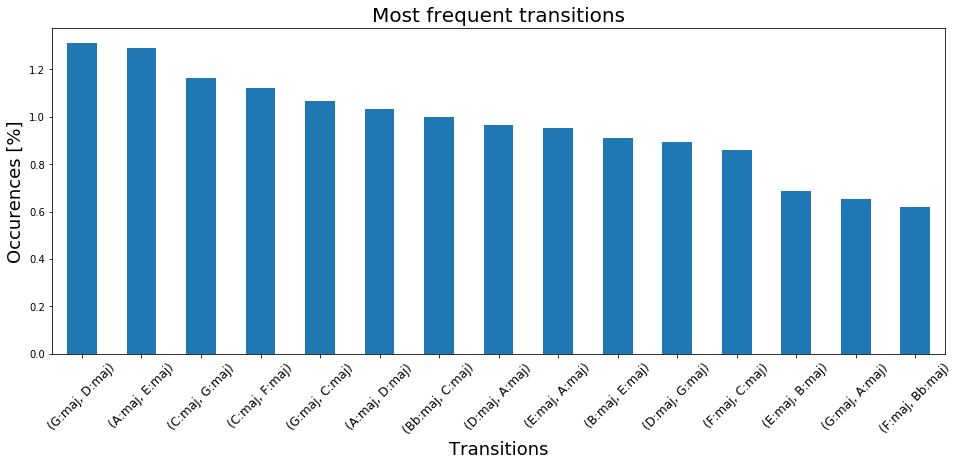

In [139]:
count_verse_chords = count_bigrams(df = collection_df, 
                            chord_representation = 'chord', 
                            subsection = 'verse',
                            normalize = True)
markov_heatmap(count_verse_chords, order = 'none', hide_diag = True)
top_transition(count_verse_chords)

#### Chorus:

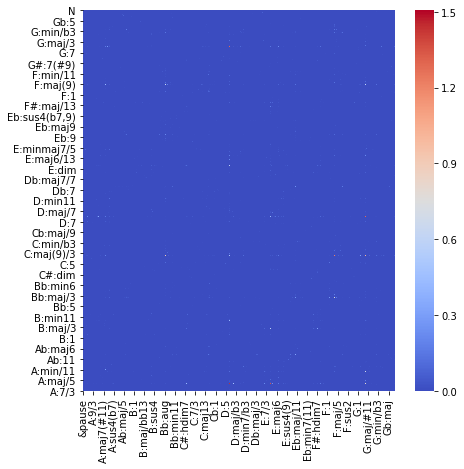

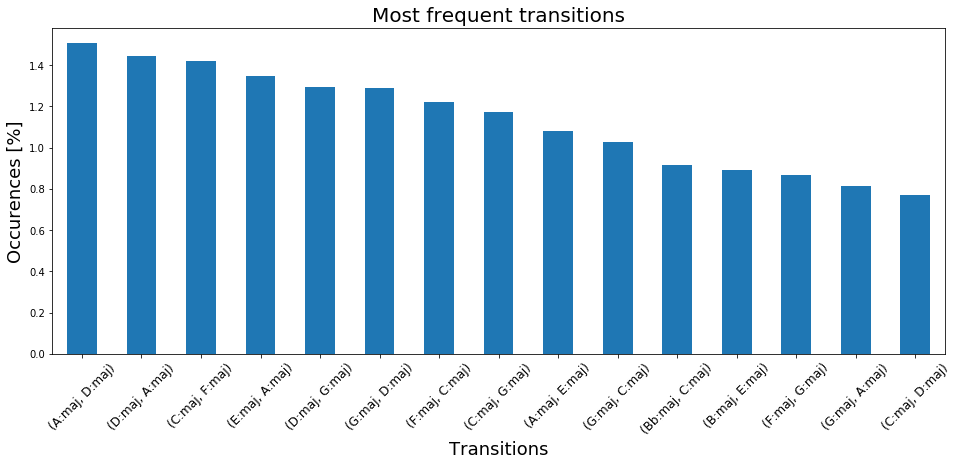

In [140]:
count_chorus_chords = count_bigrams(df = collection_df, 
                            chord_representation = 'chord', 
                            subsection = 'chorus',
                            normalize = True)
markov_heatmap(count_chorus_chords, order = 'none', hide_diag = True)
top_transition(count_chorus_chords)

#### Difference between chord transition of choruses and verses

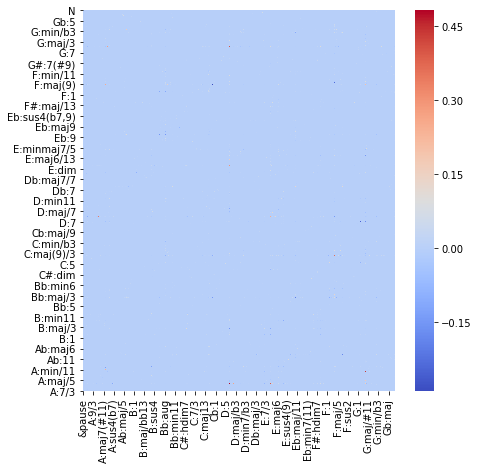

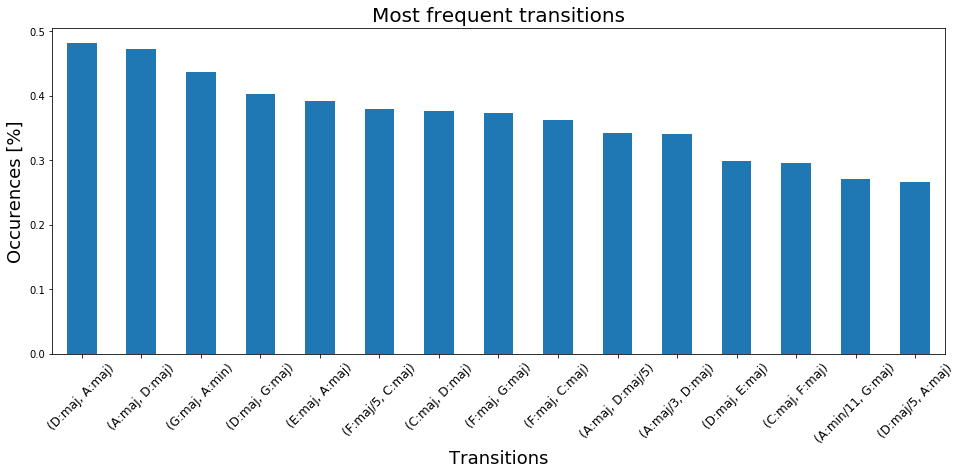

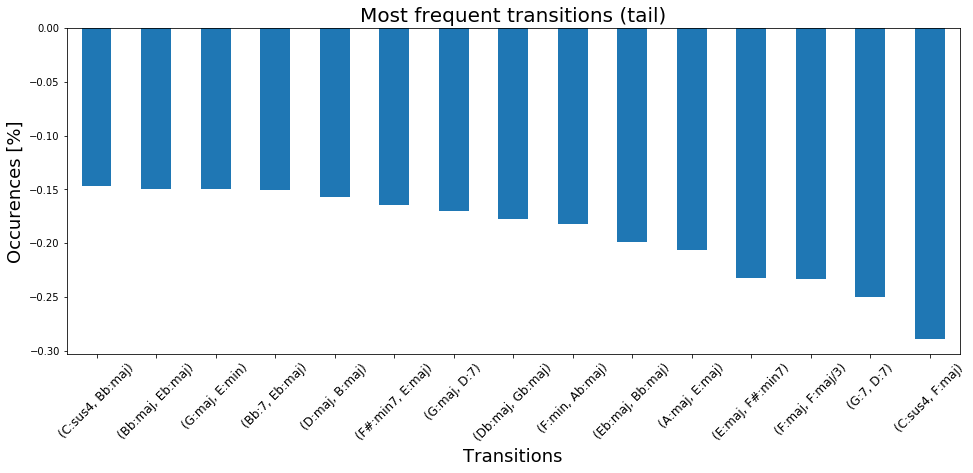

In [141]:
dif = substract_counts(count_chorus_chords, count_verse_chords)
markov_heatmap(dif, order = 'none', hide_diag = True)
top_transition(dif)
top_transition(dif, position = 'tail')

### Markov Model with the roots of the chords

#### Verse:

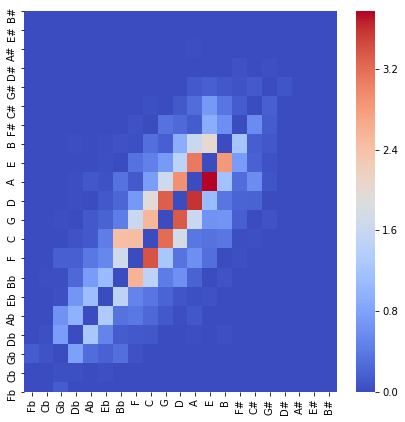

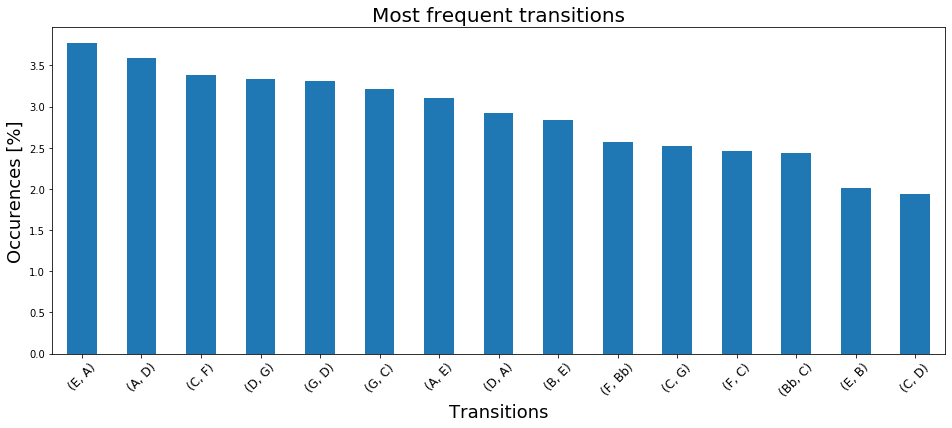

In [142]:
count_verse_roots = count_bigrams(df = collection_df, 
                            chord_representation = 'root', 
                            subsection = 'verse',
                            normalize = True)
markov_heatmap(count_verse_roots, hide_diag = True)
top_transition(count_verse_roots)

#### Chorus:

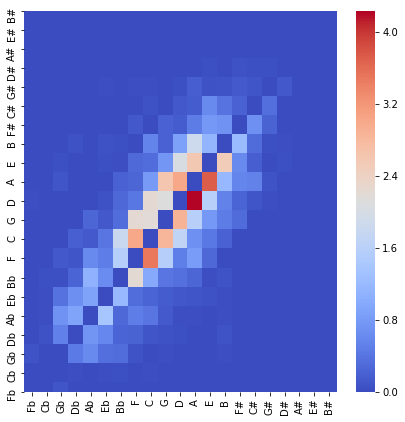

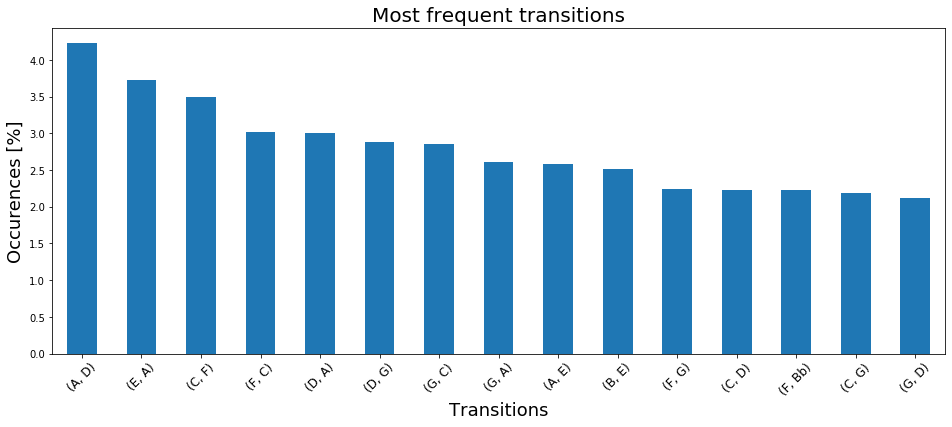

In [143]:
count_chorus_roots = count_bigrams(df = collection_df,
                                   chord_representation = 'root', 
                                   subsection = 'chorus', 
                                   normalize = True)
markov_heatmap(count_chorus_roots, hide_diag = True)
top_transition(count_chorus_roots)


#### Difference between root chord transition of choruses and verses

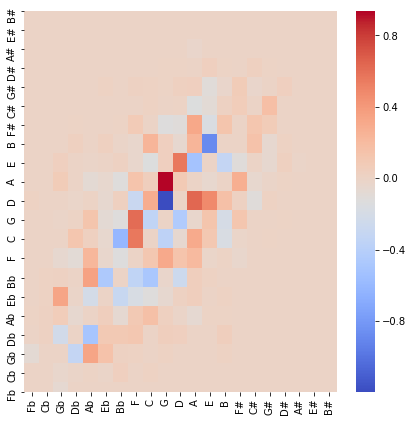

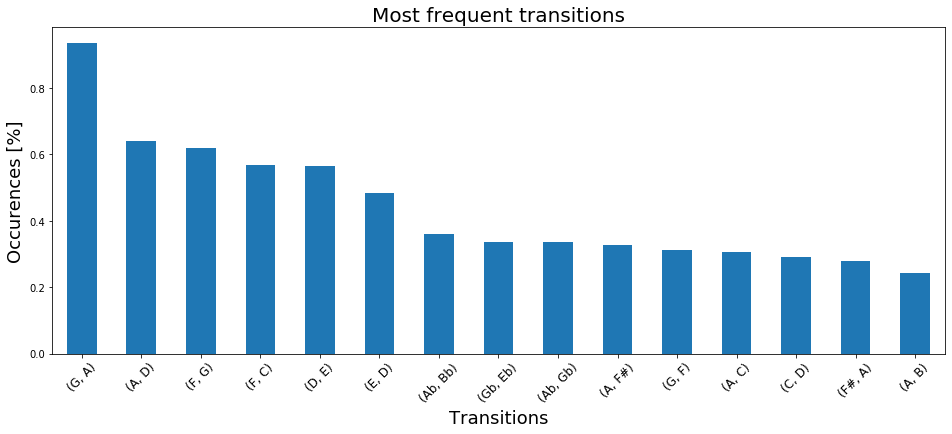

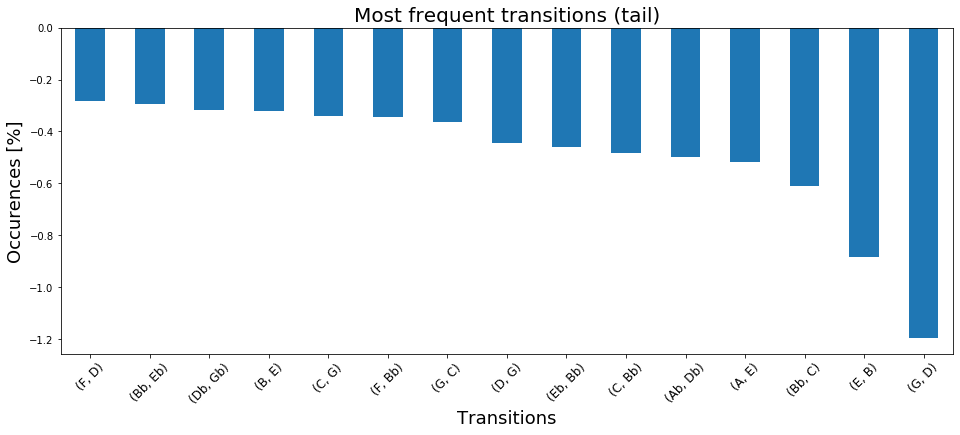

In [144]:
dif = substract_counts(count_chorus_roots, count_verse_roots)
markov_heatmap(dif, hide_diag = True)
top_transition(dif)
top_transition(dif, position = 'tail')

#### Bonus : Difference between chord transition of choruses and intros

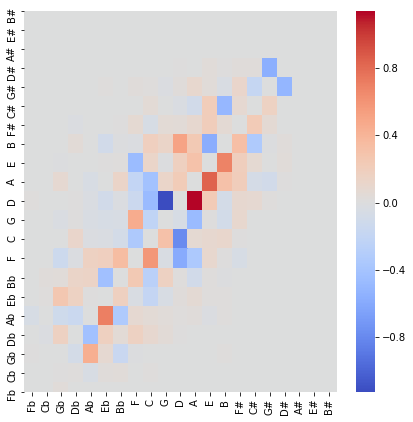

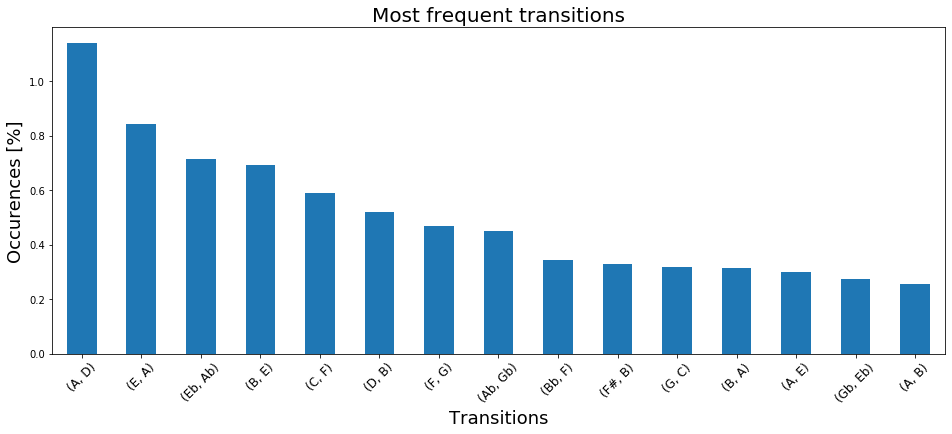

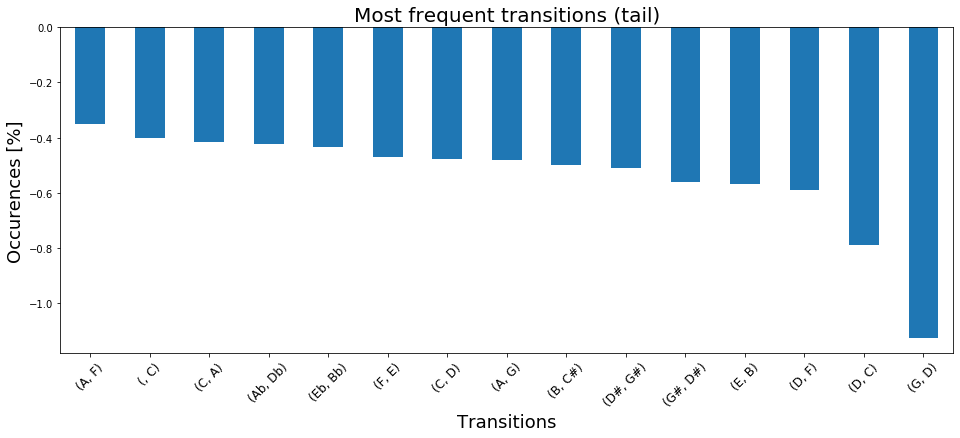

In [145]:
count_intro_roots = count_bigrams(df = collection_df,
                                  chord_representation = 'root', 
                                  subsection = 'intro', 
                                  normalize = True)
dif=substract_counts(count_chorus_roots, count_intro_roots)
markov_heatmap(dif,hide_diag=True)
top_transition(dif)
top_transition(dif,position="tail")